In [1]:
import torch_geometric
import data_utils
import model
import torch
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
import networkx as nx
import time
import sklearn

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=False),
])
dataset = Planetoid('../dataset', 'cora', transform=transform)
train_data, val_data, test_data = dataset[0]


def visualize_graph(G, color, pos=None):
    #plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    if pos == None:
        pos=nx.spring_layout(G, seed=42)
    nx.draw_networkx(G,  with_labels=False,
                     node_color=color, cmap="Set2", node_size=2, arrows=False)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    #plt.xticks([])
    #plt.yticks([])
    #plt.xlim([-2,2])
    #plt.ylim([-2,2])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=20, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

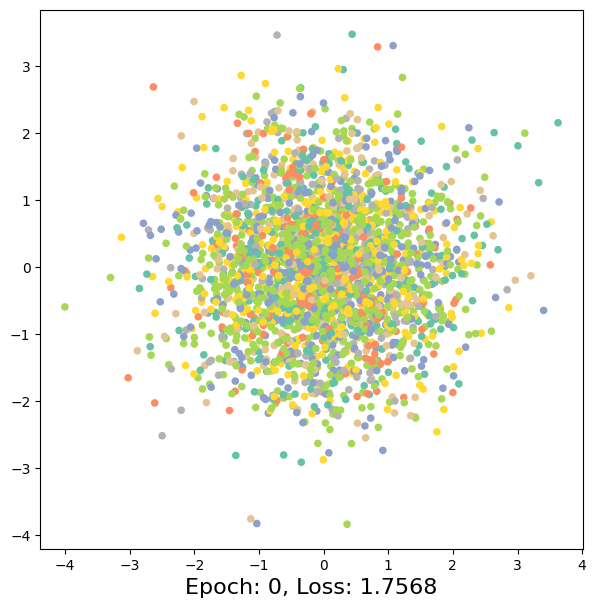

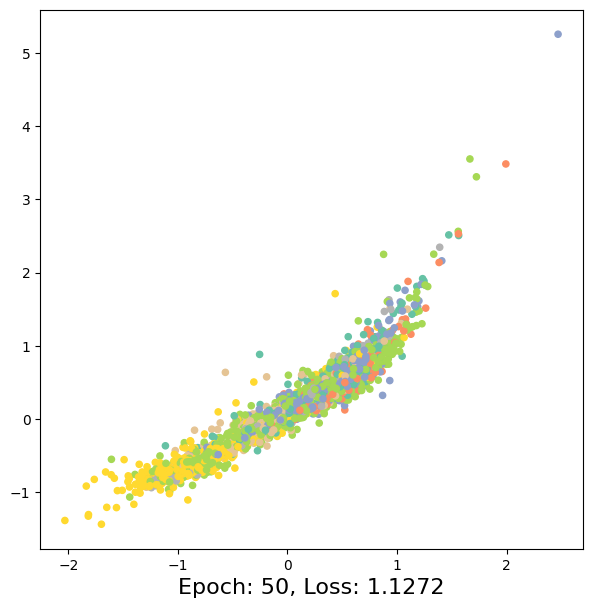

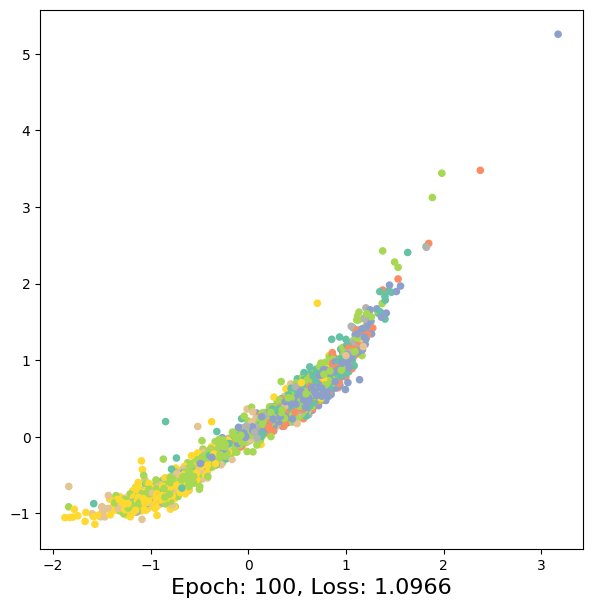

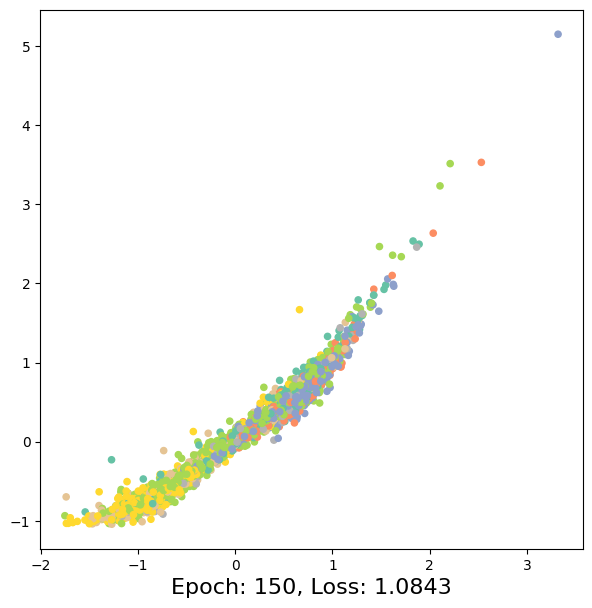

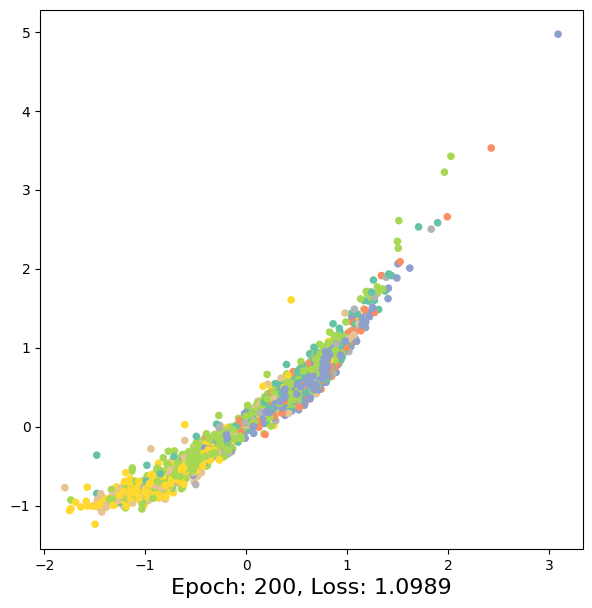

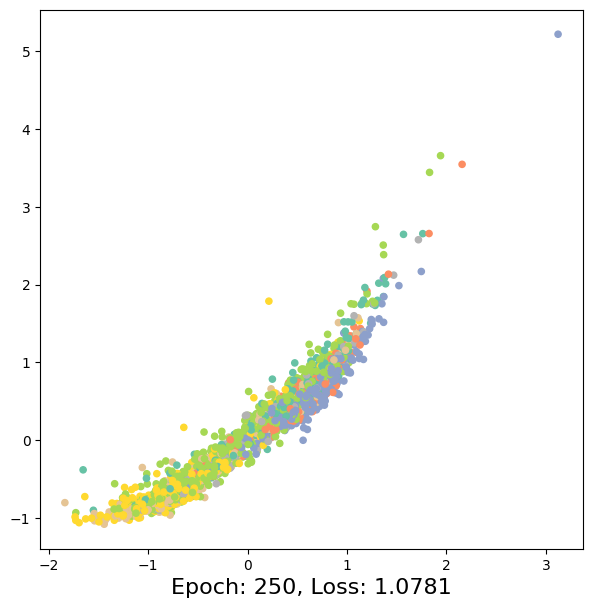

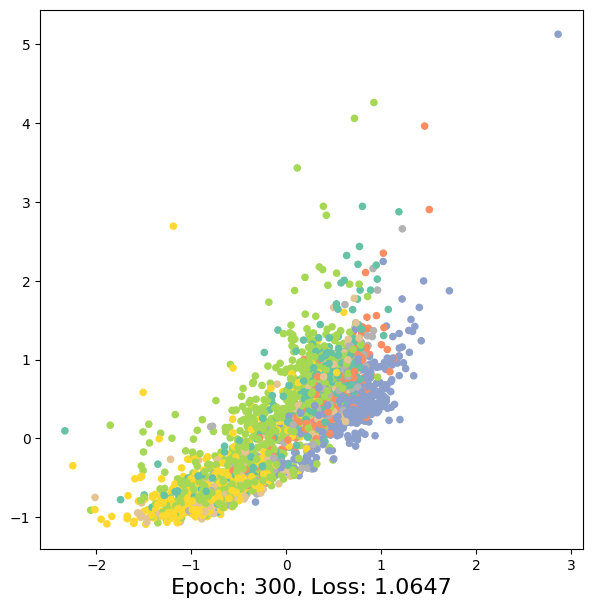

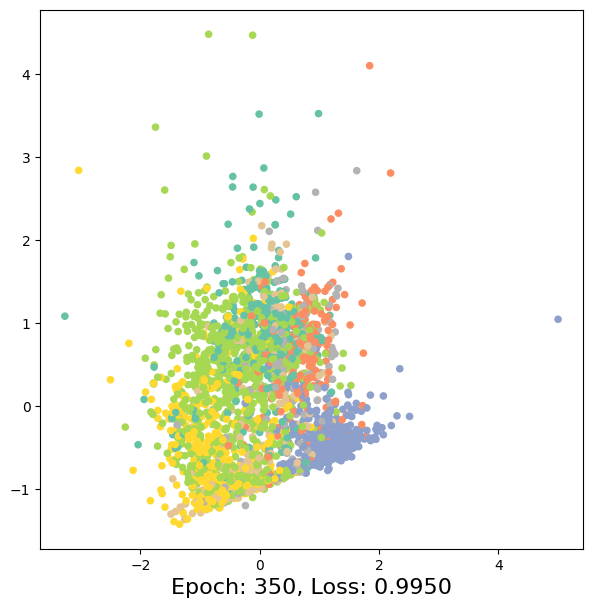

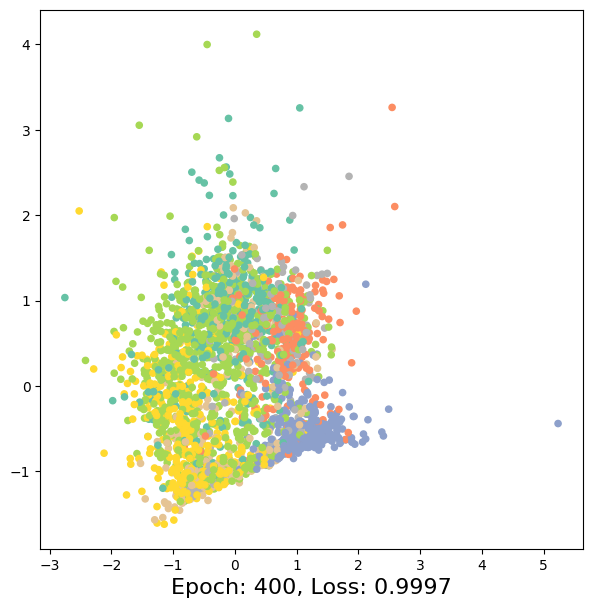

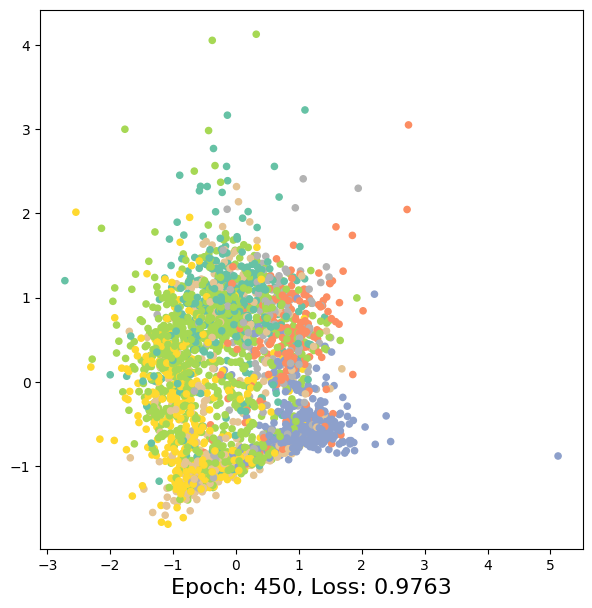

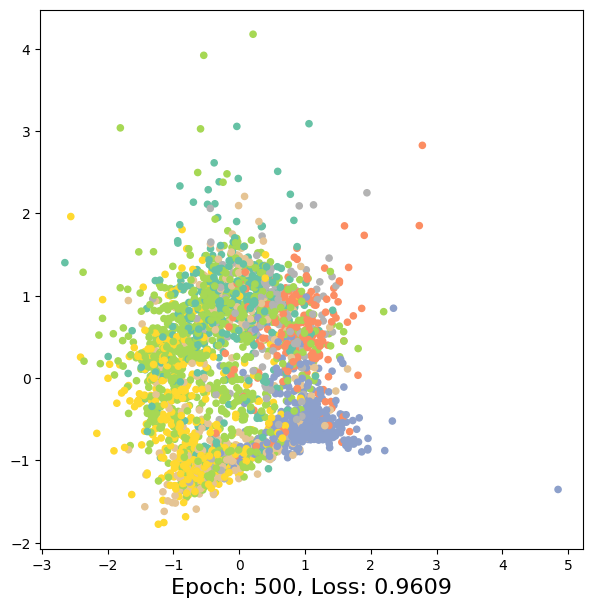

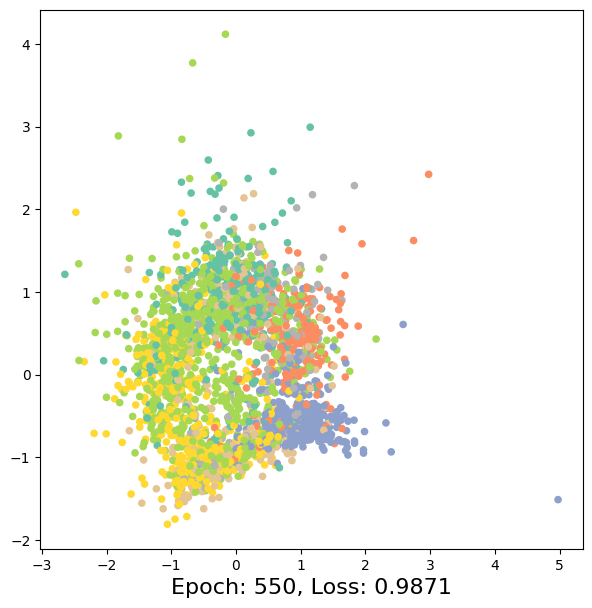

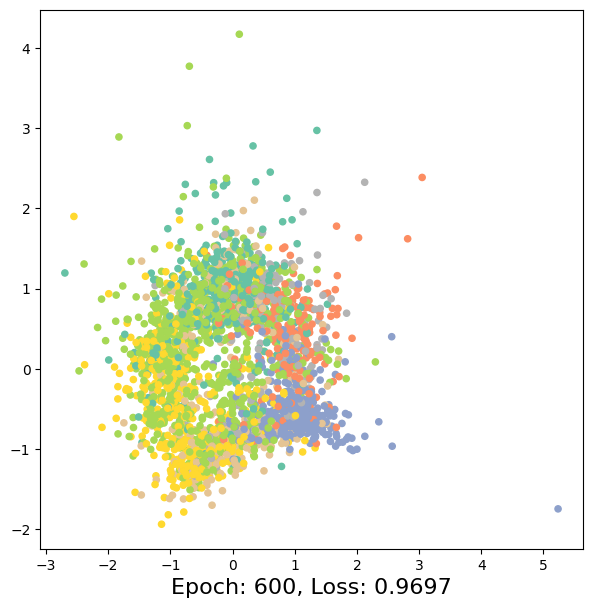

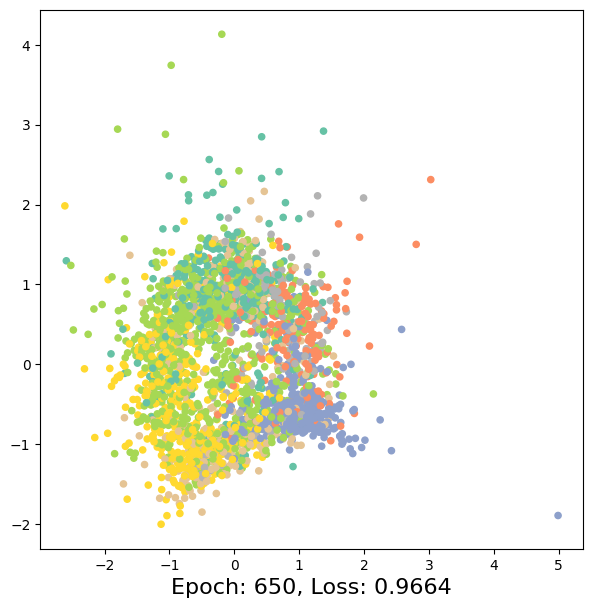

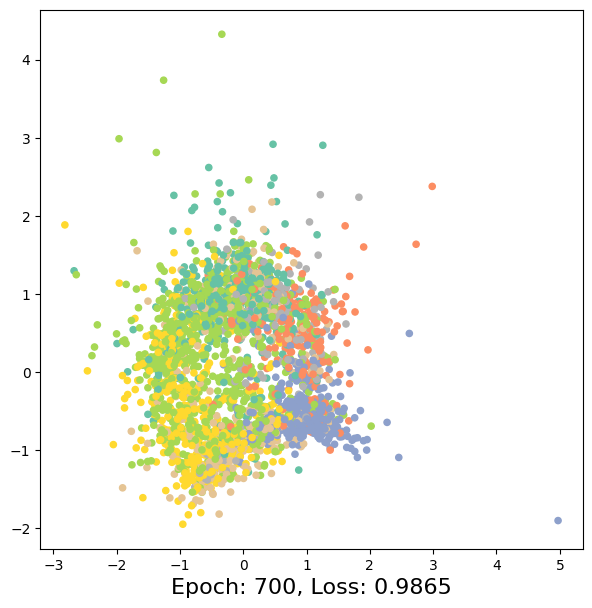

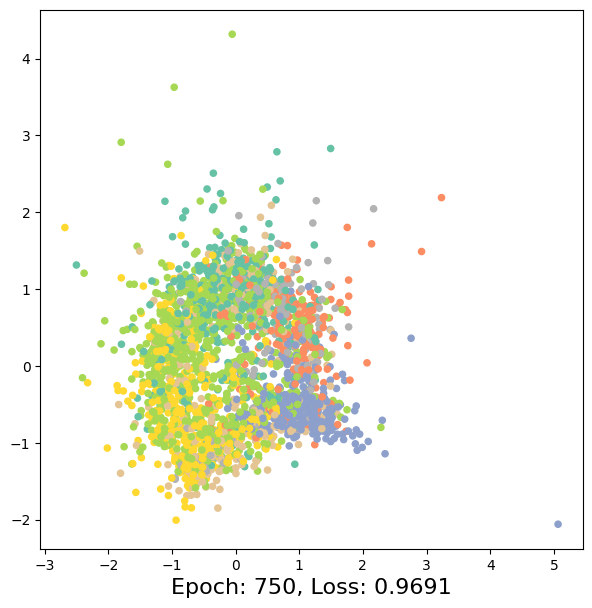

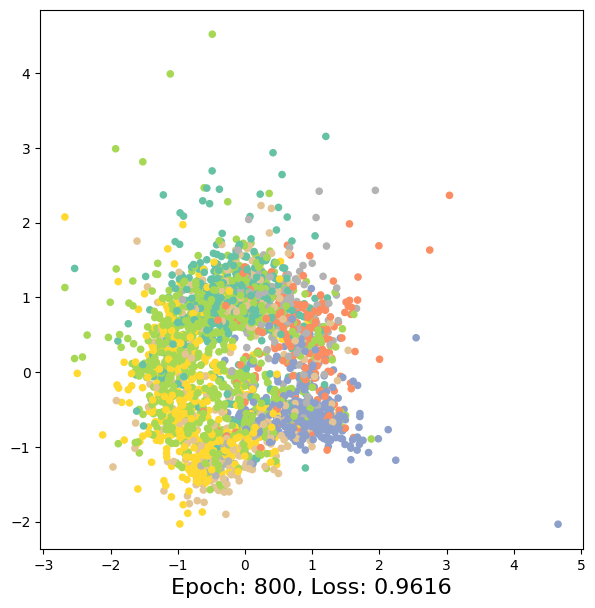

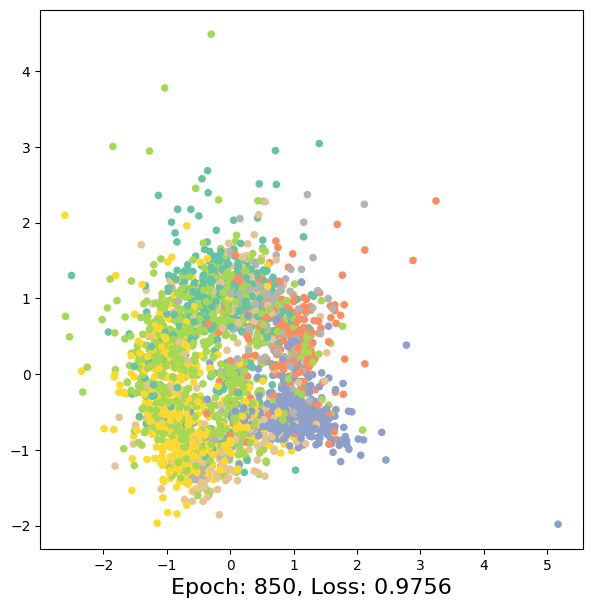

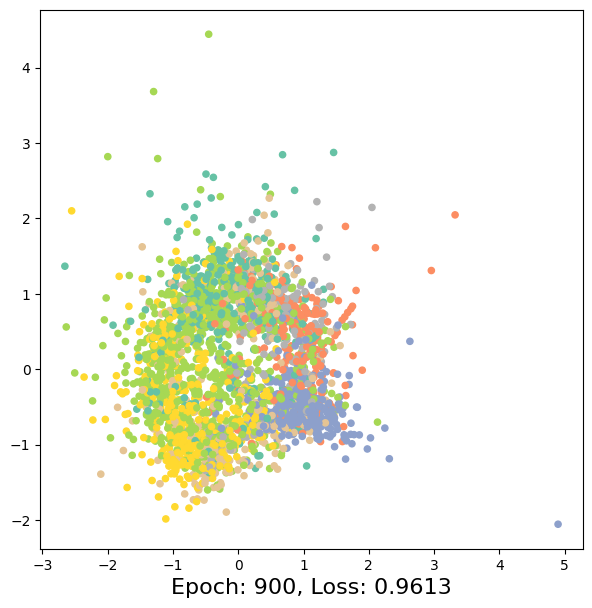

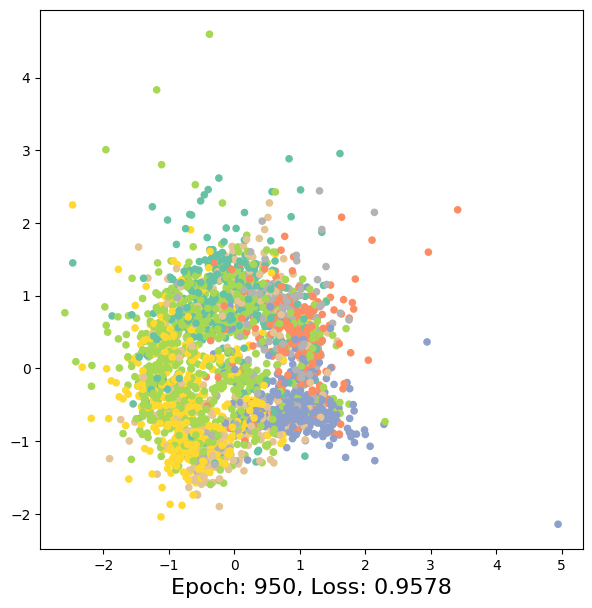

In [8]:
import importlib
import model
importlib.reload(model)
embedding_dim = 2

class VariationalGCN(torch.nn.Module):
    def __init__(self, num_features, embedding_dim):
        super().__init__()
        self.conv1 = model.GCNConv(num_features, 2*embedding_dim)
        self.mu_encoder = model.GCNConv(2*embedding_dim, embedding_dim)
        self.logstd_encoder = model.GCNConv(2*embedding_dim, embedding_dim)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.mu_encoder(x, edge_index), self.logstd_encoder(x, edge_index)
    

vae = torch_geometric.nn.models.VGAE(
    encoder=VariationalGCN(dataset.num_features, embedding_dim),
    decoder=None
)
optimizer = torch.optim.Adam(vae.parameters(), lr=0.05)  # Define optimizer.


def train(data):
    vae.train()
    optimizer.zero_grad()  # Clear gradients.

    # FORWARD
    #A_recon = vae(data.x, data.edge_index) 
    # LOSS
    #reconstruction_loss = torch.nn.functional.cross_entropy(x_recon[data.train_mask], data.y[data.train_mask], reduction='mean')
    #reconstruction_loss = torch.nn.functional.binary_cross_entropy(A_recon, to_dense_adj(data.edge_index).reshape(-1), reduce='sum')
    #KLD = (0.5 / data.num_nodes) * torch.mean(torch.sum(1 + 2*log_std - mu.pow(2) - log_std.exp().pow(2), dim=1))

    z = vae.encode(data.x, data.edge_index)

    recon_loss = vae.recon_loss(z, data.pos_edge_label_index)
    #kld = vae.kl_loss(mu, log_std)
    kld = vae.kl_loss()

    loss = recon_loss + 1/data.num_nodes * kld


    # OPTIMIZATION STEP
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.


    return float(loss), vae.decode(z, data.edge_index), z, float(kld), float(recon_loss)


@torch.no_grad()
def test(data):
    vae.eval()
    z = vae.encode(data.x, data.edge_index)
    return vae.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

losses = []
epochs = 1000
for epoch in range(epochs):
    loss, A_recon, z, kld, recon_loss = train(train_data)
    with torch.no_grad():
        #train_accuracy = torch.equal(torch.greater_equal(A_recon, 0.5).float(), train_data.edge_index)
        auc, ap = test(val_data)
        losses.append([loss, kld, recon_loss, auc, ap])
        if epoch % 50 == 0 and embedding_dim == 2:
            visualize_embedding(z, color=train_data.y, epoch=epoch, loss=torch.tensor(loss))
            time.sleep(0.3)

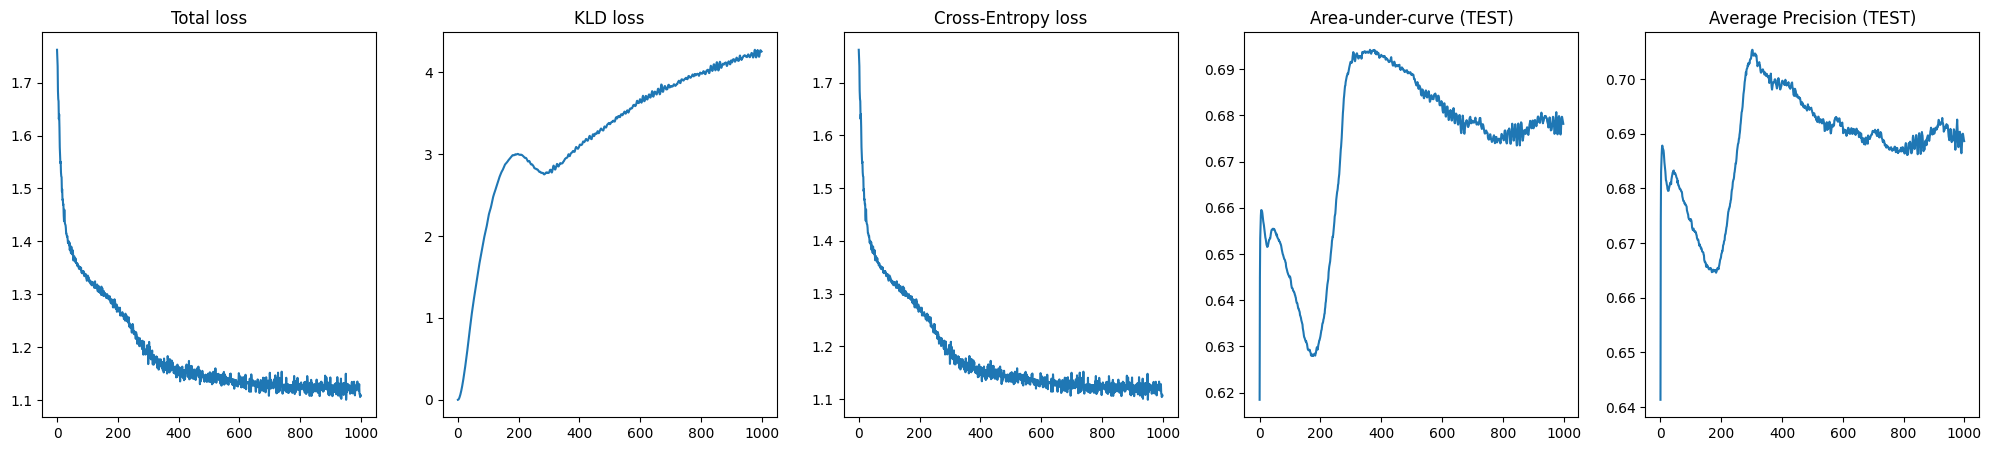

In [4]:
fig, axs = plt.subplots(1,5, figsize=(25,5))
for i in range(5):
    axs[i].plot([l[i] for l in losses])
    axs[i].set_title(['Total loss', 'KLD loss', 'Cross-Entropy loss', 'Area-under-curve (TEST)', 'Average Precision (TEST)'][i])
    #axs[i].set_xscale('log')
plt.show()

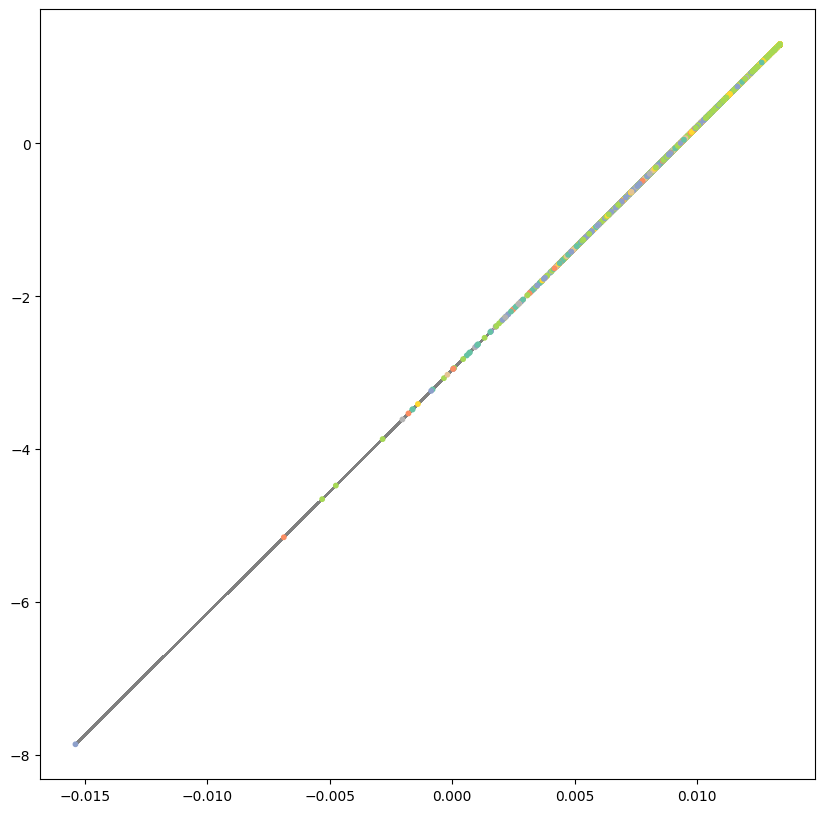

In [5]:
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from matplotlib.collections import LineCollection

with torch.no_grad():
    z = vae.encode(test_data.x, test_data.edge_index)
    edge_probs = vae.decoder.forward(z, test_data.edge_index)
    edge_on_off = torch.greater_equal(edge_probs, 0.5) 
    data_copy = Data(x=z, pos=z, edge_index=test_data.edge_index, edge_attr=test_data.edge_attrs, y=test_data.y)
    
    #G = to_networkx(test_data, to_undirected=False, remove_self_loops=True)
    #G_z = to_networkx(data_copy, to_undirected=False, remove_self_loops=True)

    fig, axs = plt.subplots(1,1, figsize=(10,10))
    pos = {}
    for node, node_pos in enumerate(z):
        pos[node] = node_pos
    axs.scatter(z[:,0], z[:, 1], s=10, cmap='Set2', c=test_data.y, zorder=2)

    for idx, edge in enumerate(zip(test_data.edge_index[0], test_data.edge_index[1])):
        if edge_on_off[idx]:
            i = edge[0]
            j = edge[1]
            plt.plot([z[i, 0].item(), z[j, 0].item()],
                    [z[i, 1].item(), z[j, 1].item()],
                    color="gray", zorder=1, alpha=0.1)

    #lc = LineCollection(z[edge_on_off])
    #nx.draw_networkx(G, with_labels=False, node_color=test_data.y, cmap='Set2', node_size=2, arrows=False, ax=axs[0])
    #nx.draw_networkx(G_z,  with_labels=False,
    #                 node_color=test_data.y, cmap="Set2", node_size=2, arrows=False, ax=axs)
    #visualize_graph(G, color=test_data.y, pos=z)